# `astrovision` tutorial

This notebook showcases the different functionalities of the `astrovision` library.

## `SatelliteImage`

The `SatelliteImage` class represents a satellite image. It models raster-like objects. One can instantiate a `SatelliteImage` object from a raster file as follows: 

In [1]:
from astrovision.data.satellite_image import (
    SatelliteImage,
)

example_path = "../tests/test_data/ORT_2020052526656219_0509_8593_U38S_8Bits.jp2"
satellite_image = SatelliteImage.from_raster(example_path)

/opt/mamba/lib/python3.10/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


The `SatelliteImage` object has the following attributes:
- `array`: pixel values of the satellite image;
- `crs`: coordinate reference system chosen (of the form "EPSG:\<code\>");
- `bounds`: bound coordinates;
- `transform`: affine transform for getting pixel coordinates.

Optionally, the `from_raster` method takes arguments:
- `dep`: Optional *département* of the image. Stored as a class attribute;
- `date`: Optional date. Stored as a class attribute;
- `n_bands`: Number of bands in the raster file. Defaults to 3;
- `channels_first`: Whether channels should be moved to the first axis. Defaults to `True`; 
- `cast_to_float`: Whether to cast pixel values array to `float`. Defaults to `False`.

The `normalize` method returns a `SatelliteImage` normalized with (channel-wise) min-max normalization after clipping at a quantile given by the `quantile` argument (defaults to 0.97).

In [2]:
print(f"Mean pixel value of the original image: {satellite_image.array.mean()}")
normalized_image = satellite_image.normalize()
print(f"Mean pixel value of the normalized image: {normalized_image.array.mean()}")

Mean pixel value of the original image: 55.99315308333333
Mean pixel value of the normalized image: 0.5256782016364299


A normalized image can easily be plotted using the `plot` method, specifying the bands indices that should be used (one usually wants to plot the RGB bands).

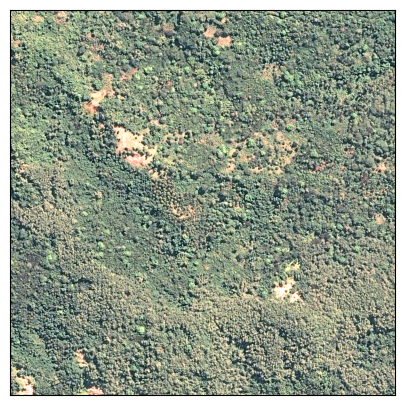

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
normalized_image.plot(bands_indices=[0, 1, 2])

The `split` method allows to split an image in smaller tiles of size specified by the `tile_length` argument. If `tile_length` does not divide the image size, there will be some overlay for the last two tiles of each row and/or column.

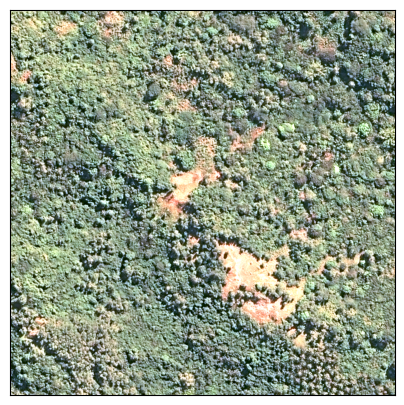

<Figure size 640x480 with 0 Axes>

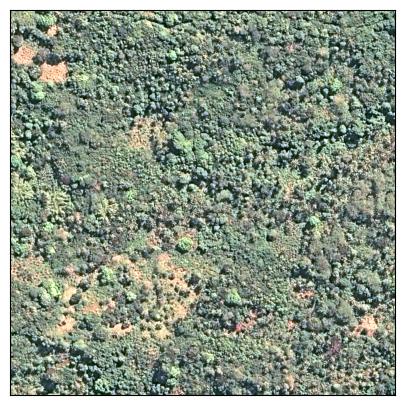

<Figure size 640x480 with 0 Axes>

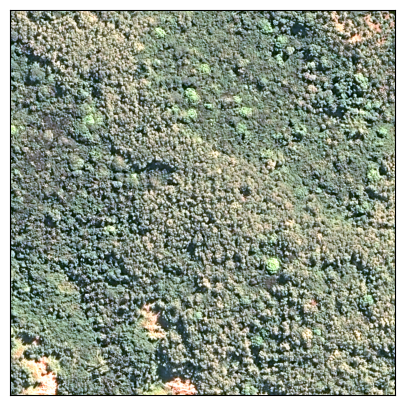

<Figure size 640x480 with 0 Axes>

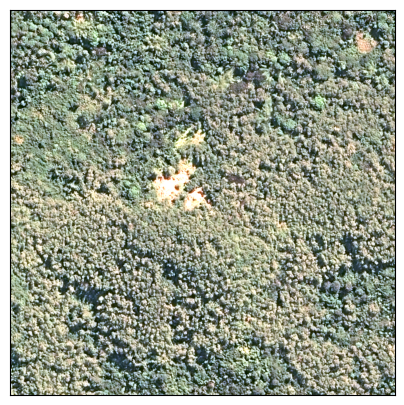

<Figure size 640x480 with 0 Axes>

In [4]:
tiles = normalized_image.split(tile_length=1000)
for tile in tiles:
    tile.plot(bands_indices=[0, 1, 2])

### Intersections with geographic objects

3 methods allow to check if a `SatelliteImage` intersects a geographic object:

- The `intersects_box` method returns `True` if the image intersects a bounding box specified by the coordinates `box_bounds` and the CRS `crs`, and `False` otherwise;
- The `intersects_polygon` method returns `True` if the image intersects a bounding box specified by the geometry `polygon_geometry` and the CRS `crs`, and `False` otherwise;
- The `contains` method returns `True` if the image contains a point specified by coordinates `coordinates` and the CRS `crs`, and `False` otherwise.

In [5]:
box_bounds = satellite_image.bounds
crs = satellite_image.crs
satellite_image.intersects_box(box_bounds=box_bounds, crs=crs)

True

In [6]:
from shapely import geometry

box_bounds = satellite_image.bounds
crs = satellite_image.crs
polygon = geometry.box(*box_bounds)

satellite_image.intersects_polygon(polygon_geometry=polygon, crs=crs)

True

In [7]:
coordinates = (509500.0, 8592500.0)
crs = "EPSG:4471"

satellite_image.contains(coordinates=coordinates, crs=crs)

True

### Exporting `SatelliteImage` objects

The `to_tensor` method returns a `torch.Tensor` containing pixel values.

In [8]:
tensor = satellite_image.to_tensor()
print(tensor.shape)

torch.Size([3, 2000, 2000])


The `to_raster` method allows to export the `SatelliteImage` to a raster file stored at path `file_path`. Currently the `.jp2` and `.tif` extensions are supported.

## Labeled satellite images

`astrovision` implements classes that represent satellite images annotated with a segmentation (`SegmentationLabeledSatelliteImage`), a classification (`ClassificationLabeledSatelliteImage`), or an object detection (`DetectionLabeledSatelliteImage`) label. Objects from these classes can be instantiated with a `SatelliteImage` and a label which depends on the label type. The segmentation and labeled classes have a `split` (not implemented yet for detection) as well as a `plot` method which are illustrated below. The classification class has a `plot` method as well.

In [9]:
import numpy as np
from astrovision.data.labeled_satellite_image import (
    SegmentationLabeledSatelliteImage,
    ClassificationLabeledSatelliteImage,
    DetectionLabeledSatelliteImage,
)

label = np.zeros(satellite_image.array.shape[1:])
label[500:1500, 500:1500] = 1
segmentation_labeled_image = SegmentationLabeledSatelliteImage(
    satellite_image=satellite_image, label=label
)

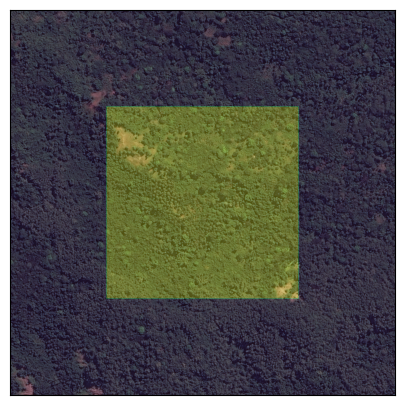

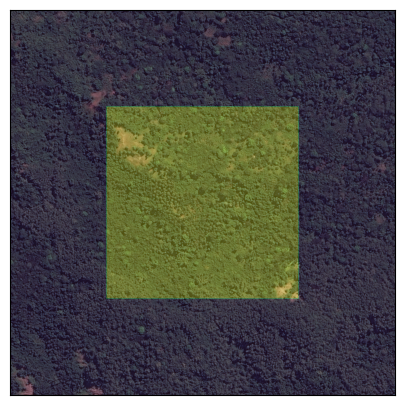

In [10]:
segmentation_labeled_image.plot(bands_indices=[0, 1, 2])

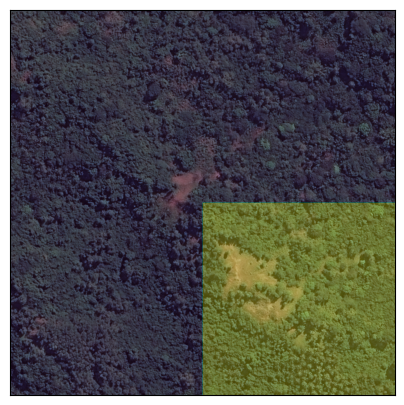

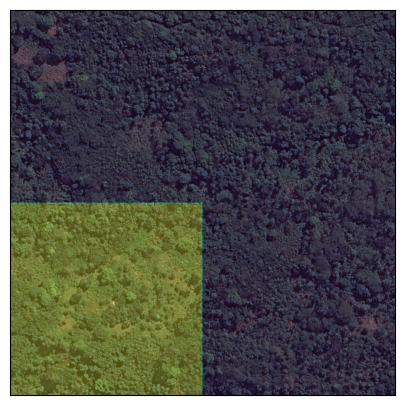

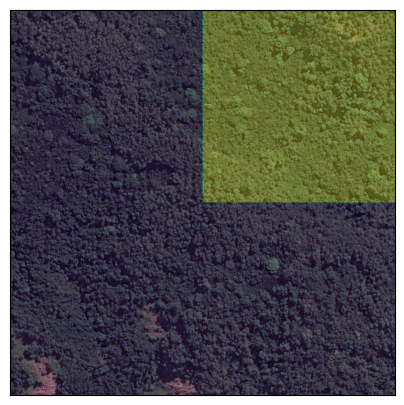

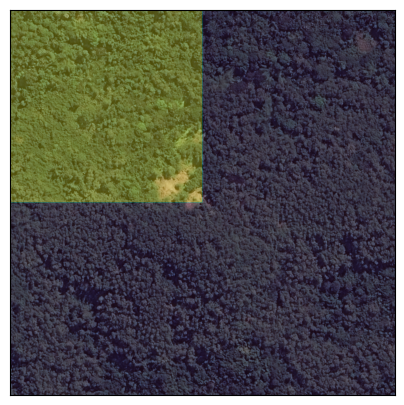

In [11]:
labeled_tiles = segmentation_labeled_image.split(tile_length=1000)
for tile in labeled_tiles:
    tile.plot(bands_indices=[0, 1, 2])

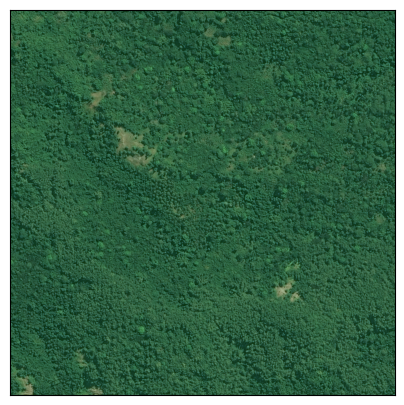

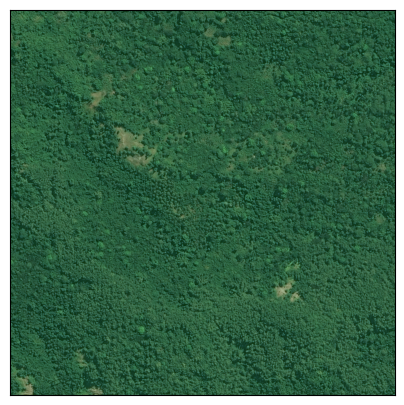

In [12]:
label = 1
classification_labeled_image = ClassificationLabeledSatelliteImage(
    satellite_image=satellite_image, label=label
)
classification_labeled_image.plot(bands_indices=[0, 1, 2])

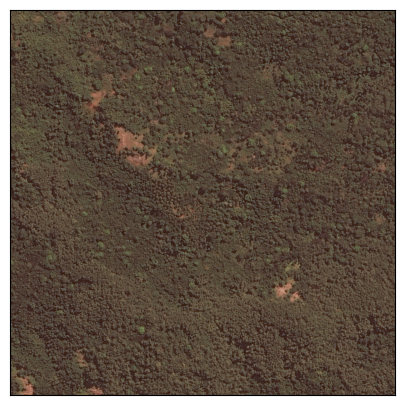

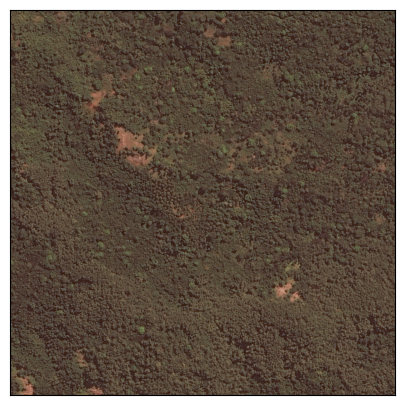

In [13]:
label = 0
classification_labeled_image = ClassificationLabeledSatelliteImage(
    satellite_image=satellite_image, label=label
)
classification_labeled_image.plot(bands_indices=[0, 1, 2])

For now to have a correct plot the `SatelliteImage` attribute of a `DetectionLabeledSatelliteImage` must have `float` values. This will be corrected later on.

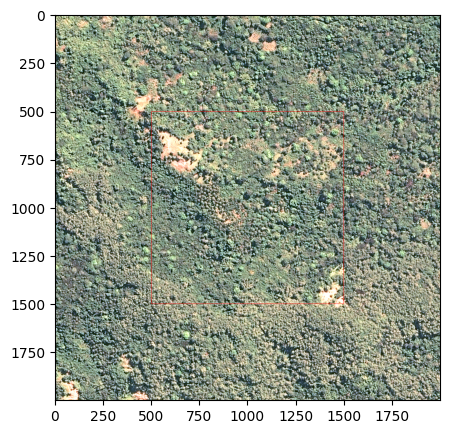

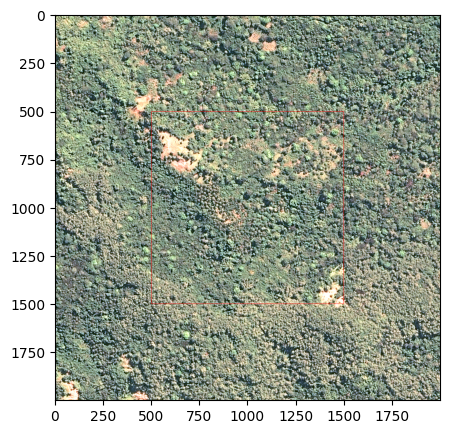

In [14]:
label = [(500, 500, 1500, 1500)]
detection_labeled_image = DetectionLabeledSatelliteImage(
    satellite_image=satellite_image.normalize(), label=label
)
detection_labeled_image.plot(bands_indices=[0, 1, 2])

## `filter` module

The `filter` module implements functions to filter lists of satellite image objects. The `filter_corrupted` can be used to filter out corrupted images from such a list (corrupted meaning the images have missing parts which are usually replaced with black pixels).

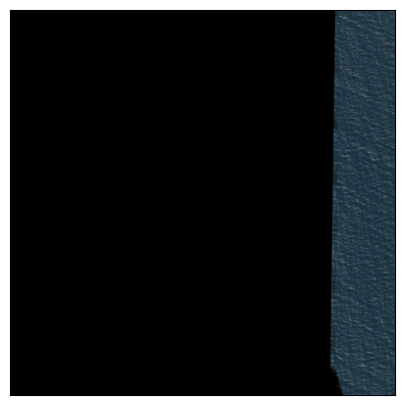

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
path_corrupted = "../tests/test_data/ORT_2020052526656219_0499_8600_U38S_8Bits.jp2"
corrupted_satellite_image = SatelliteImage.from_raster(path_corrupted)
corrupted_satellite_image.plot(bands_indices=[0, 1, 2])

In [16]:
from astrovision.filter.corruption import filter_corrupted

images = [corrupted_satellite_image]
filtered_images = filter_corrupted(images)
print(filtered_images)

[]


The `filter_cloudy` function can be used to filter out cloudy images when specifying cloud masks (which for now have to be calculated beforehand) and the `filter_oob` function can be used to filter out images that fall outside of a geographic area specified by a polygon geometry.

## `plot` module

The `plot` module implements functions to plot several `SatelliteImage` objects together on a spatial grid. The `plot_image` function is illustrated below.

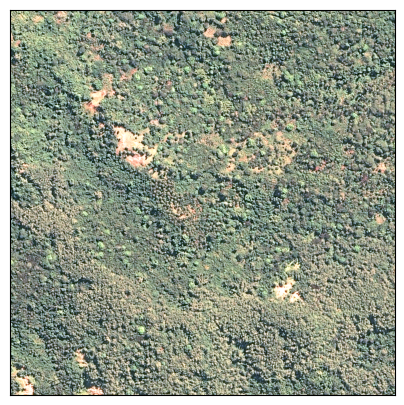

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
from astrovision.plot import plot_images

plot_images(tiles, bands_indices=[0, 1, 2])

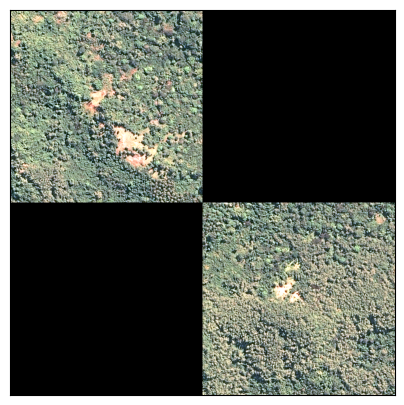

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
plot_images([tiles[i] for i in (0, 3)], bands_indices=[0, 1, 2])

## `sample` module

The `sample` module implements a function to sample from a list of satellite images. The `sample_around_coordinates` function takes as inputs a list of `SatelliteImage` objects, as well as a `distance`, a `coordinates` and a `crs` argument. It returns two lists of images, the first one with images which are within the given distance of the specified point and the second containing the others.

In [19]:
from astrovision.sample import sample_around_coordinates

# Coordinates are inside the image
coordinates = (509500.0, 8592500.0)
crs = "EPSG:4471"

inside, outside = sample_around_coordinates(
    [satellite_image], distance=10, coordinates=coordinates, crs=crs
)
print(len(inside))

1


In [20]:
# Coordinates are far away from the image
coordinates = (491500.0, 8592500.0)
crs = "EPSG:4471"

inside, outside = sample_around_coordinates(
    [satellite_image], distance=10, coordinates=coordinates, crs=crs
)
print(len(inside))

0
